In [1]:
import json

# load the reference corpora
with open('../data/corpus/middle_english_pd_sentence_ngrams_200.json') as f:
    middle_english_pd_sentence_ngrams = json.load(f)

# load the target corpora
with open('../data/corpus/reddit_sentence_ngrams_2000.json') as f:
    reddit_sentence_ngrams = json.load(f)

In [2]:
"""
The corpora are stored as JSON objects with the following structure:
{
    n-gram": {
            "count": 1,
            "documents": [...]
        }
    }
Convert the JSON object to a dictionary with the following structure:
    1. Split it into 4 dictionaries, one for each n-gram size (2-5)
    2. Each dictionary has n-grams as keys and {"count": count, "documents": [...]} as values
    3. Combine the dictionaries into a single dictionary with n=2,3,4,5 as keys
    {
        2: {
            "n-gram": {
                "count": count,
                "documents": [...]
                },
            ...
        }, 
        3: {
            "n-gram": {
                "count": count,
                "documents": [...]
                },
            ...
        },
        ...
    }
"""
def n_dict(json_obj):
    # Initialize dictionaries for each n-gram size
    ngram_dicts = {n: {} for n in range(2, 6)}
    
    # Process each n-gram in the JSON object
    for ngram, info in json_obj.items():
        # Get the n-gram size
        n = len(ngram.split())
        if 2 <= n <= 5:
            # Store the n-gram info in the appropriate dictionary
            ngram_dicts[n][ngram] = info
    
    return ngram_dicts

In [3]:
# convert the JSON objects to dictionaries
middle_english_pd_sentence_ngrams = n_dict(middle_english_pd_sentence_ngrams)

# convert the JSON objects to dictionaries
reddit_sentence_ngrams = n_dict(reddit_sentence_ngrams)

*Add a filtration step here to remove the items who have a very low count. But this is probably not necessary at this stage.*

In [4]:
from collections import defaultdict
import math

def compute_pmi_differences(target_counts, ref_counts, n, alpha=1):
    # Step 1: Compute total n-grams and unigrams for each corpus
    total_target_ngrams = sum(target_counts.values())
    total_ref_ngrams = sum(ref_counts.values())
    
    # Unigram counts (for denominator probabilities)
    target_unigram_counts = defaultdict(int)
    ref_unigram_counts = defaultdict(int)
    for ngram, count in target_counts.items():
        for word in ngram:
            target_unigram_counts[word] += count
    for ngram, count in ref_counts.items():
        for word in ngram:
            ref_unigram_counts[word] += count
    total_target_unigrams = sum(target_unigram_counts.values())
    total_ref_unigrams = sum(ref_unigram_counts.values())
    
    # Step 2: Compute PMI differences
    delta_pmi = {}
    all_ngrams = set(target_counts.keys()).union(ref_counts.keys())
    
    for ngram in all_ngrams:
        # Probabilities in target corpus
        target_count = target_counts.get(ngram, 0) + alpha
        target_prob = target_count / (total_target_ngrams + alpha * len(all_ngrams))
        target_individual_probs = [
            (target_unigram_counts.get(word, 0) + alpha) / (total_target_unigrams + alpha * len(target_unigram_counts))
            for word in ngram
        ]
        target_pmi = math.log(target_prob / math.prod(target_individual_probs), 2)
        
        # Probabilities in reference corpus
        ref_count = ref_counts.get(ngram, 0) + alpha
        ref_prob = ref_count / (total_ref_ngrams + alpha * len(all_ngrams))
        ref_individual_probs = [
            (ref_unigram_counts.get(word, 0) + alpha) / (total_ref_unigrams + alpha * len(ref_unigram_counts))
            for word in ngram
        ]
        ref_pmi = math.log(ref_prob / math.prod(ref_individual_probs), 2)
        
        # PMI difference
        delta_pmi[ngram] = target_pmi - ref_pmi
    
    return delta_pmi

# Example usage
target_counts = {
    ('this', 'is'): 10,
    ('corpus', 'is'): 5,
    ('n-grams', 'are'): 2
}
ref_counts = {
    ('this', 'is'): 50,
    ('corpus', 'is'): 10,
    ('n-grams', 'are'): 1
}
n = 2  # For bigrams

delta_pmi = compute_pmi_differences(target_counts, ref_counts, n)
for ngram, delta in delta_pmi.items():
    print(f"ΔPMI({ngram}) = {delta}")

ΔPMI(('this', 'is')) = 0.20224430685568917
ΔPMI(('corpus', 'is')) = 0.20224430685568873
ΔPMI(('n-grams', 'are')) = -2.313455531428354


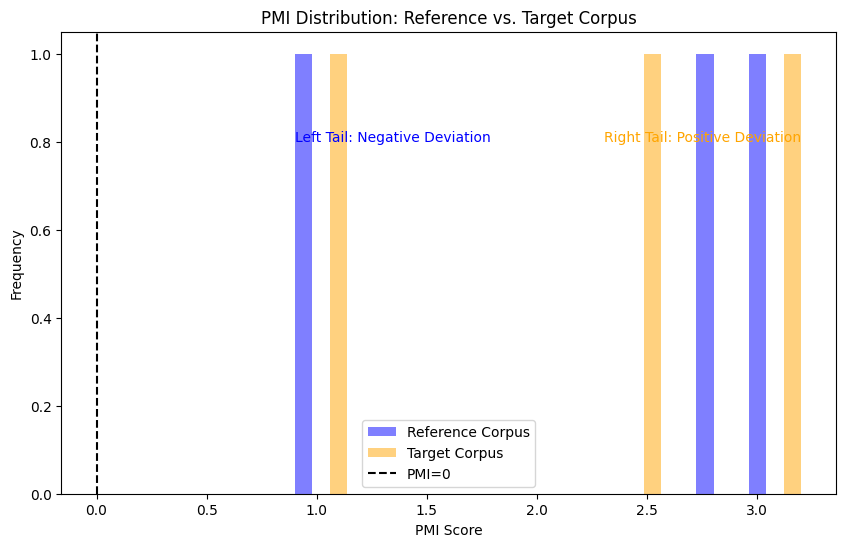

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pmi_histograms(delta_pmi, target_pmis, ref_pmis, bins=30):
    # Prepare data
    all_pmis = list(target_pmis.values()) + list(ref_pmis.values())
    min_pmi, max_pmi = min(all_pmis), max(all_pmis)
    bin_edges = np.linspace(min_pmi, max_pmi, bins)
    
    # Target and reference histograms
    target_hist, _ = np.histogram(list(target_pmis.values()), bins=bin_edges)
    ref_hist, _ = np.histogram(list(ref_pmis.values()), bins=bin_edges)
    
    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(list(ref_pmis.values()), bins=bin_edges, alpha=0.5, label="Reference Corpus", color="blue")
    plt.hist(list(target_pmis.values()), bins=bin_edges, alpha=0.5, label="Target Corpus", color="orange")
    
    # Add labels and legend
    plt.xlabel("PMI Score")
    plt.ylabel("Frequency")
    plt.title("PMI Distribution: Reference vs. Target Corpus")
    plt.axvline(0, color='black', linestyle='--', label="PMI=0")
    plt.legend()
    
    # Annotate regions
    plt.text(min_pmi, max(target_hist) * 0.8, "Left Tail: Negative Deviation", color="blue", ha="left")
    plt.text(max_pmi, max(target_hist) * 0.8, "Right Tail: Positive Deviation", color="orange", ha="right")
    plt.show()

# Example Data
target_pmis = {('this', 'is'): 3.2, ('corpus', 'is'): 1.1, ('n-grams', 'are'): 2.5}
ref_pmis = {('this', 'is'): 2.8, ('corpus', 'is'): 0.9, ('n-grams', 'are'): 3.0}

plot_pmi_histograms(delta_pmi={}, target_pmis=target_pmis, ref_pmis=ref_pmis)

In [6]:
from tqdm import tqdm

"""Compute the PMI differences for each n-gram size across the corpora
and store them as a JSON object with the following structure:
{
    n: {
        "n-gram":
            {delta_pmi: value,
            count: value,
            documents: value},
        ...
    }
}
"""

# Initialize dictionary to store PMI differences
pmi_differences = {}

# For each n-gram size (2-5)
for n in tqdm(range(2, 6)):
    # Extract counts for current n-gram size from both corpora
    target_counts = {k: v['count'] for k, v in reddit_sentence_ngrams[n].items()}
    ref_counts = {k: v['count'] for k, v in middle_english_pd_sentence_ngrams[n].items()}
    
    # Compute PMI differences for current n-gram size
    delta_pmi = compute_pmi_differences(target_counts, ref_counts, n)
    
    # Store results with additional metadata
    pmi_differences[n] = {}
    for ngram in set(target_counts.keys()) | set(ref_counts.keys()):
        pmi_differences[n][ngram] = {
            'delta_pmi': delta_pmi[ngram],
            'count': target_counts.get(ngram, 0),
            'documents': reddit_sentence_ngrams[n].get(ngram, {}).get('documents', [])
        }

# Save the results to a JSON file
with open('../data/corpus/pmi_differences.json', 'w') as f:
    json.dump(pmi_differences, f, indent=2)

100%|██████████| 4/4 [00:49<00:00, 12.28s/it]


In [7]:
# show the top 10 PMI differences for each n-gram size
for n in pmi_differences:
    print(f"Top 10 PMI Differences for n={n}")
    sorted_ngrams = sorted(pmi_differences[n].items(), key=lambda x: x[1]['delta_pmi'], reverse=True)
    for ngram, info in sorted_ngrams[:10]:
        print(f"{ngram}: ΔPMI={info['delta_pmi']:.2f} (Count={info['count']})")

Top 10 PMI Differences for n=2
2882888 990930993: ΔPMI=40.52 (Count=0)
078787878787 or: ΔPMI=38.68 (Count=1)
damage 078787878787: ΔPMI=38.24 (Count=1)
990930993 3250999: ΔPMI=37.95 (Count=0)
like 10131726364656: ΔPMI=37.42 (Count=1)
standard 10131726364656: ΔPMI=37.02 (Count=1)
bottom 10131730425464: ΔPMI=36.95 (Count=1)
tried 10131726364660: ΔPMI=36.80 (Count=1)
10131726364656 set: ΔPMI=36.76 (Count=1)
10131726364656 tension: ΔPMI=36.71 (Count=1)
Top 10 PMI Differences for n=3
2882888 990930993 3250999: ΔPMI=55.07 (Count=0)
1619811 12 1241711101: ΔPMI=49.30 (Count=0)
078787878787 or 79: ΔPMI=43.96 (Count=1)
1640we 449 0464460322: ΔPMI=41.65 (Count=0)
1300 gauges 111519283858: ΔPMI=39.38 (Count=1)
1241711101 118 31: ΔPMI=39.10 (Count=0)
12 1241711101 118: ΔPMI=39.03 (Count=0)
thereto 2882888 990930993: ΔPMI=38.98 (Count=0)
damage 078787878787 or: ΔPMI=37.67 (Count=1)
heavy bottom 10131730425464: ΔPMI=36.53 (Count=1)
Top 10 PMI Differences for n=4
154 1619811 12 1241711101: ΔPMI=56.11 (

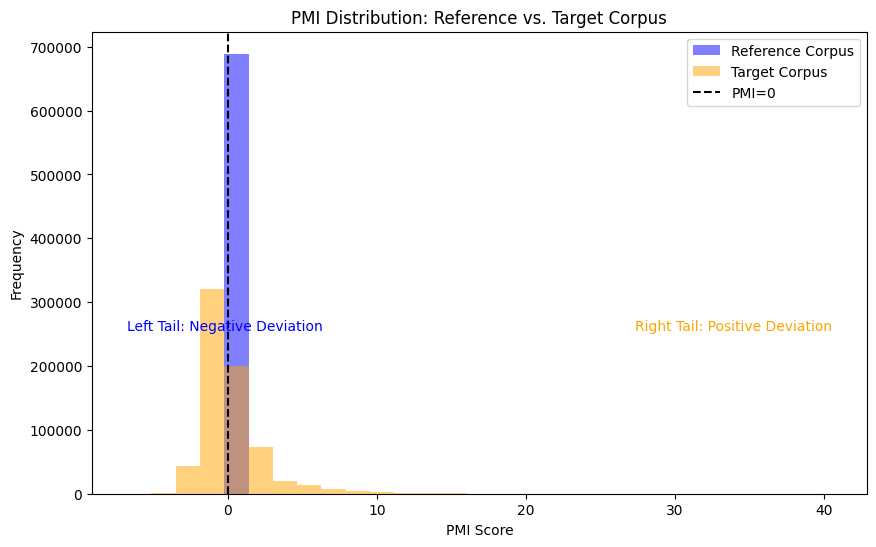

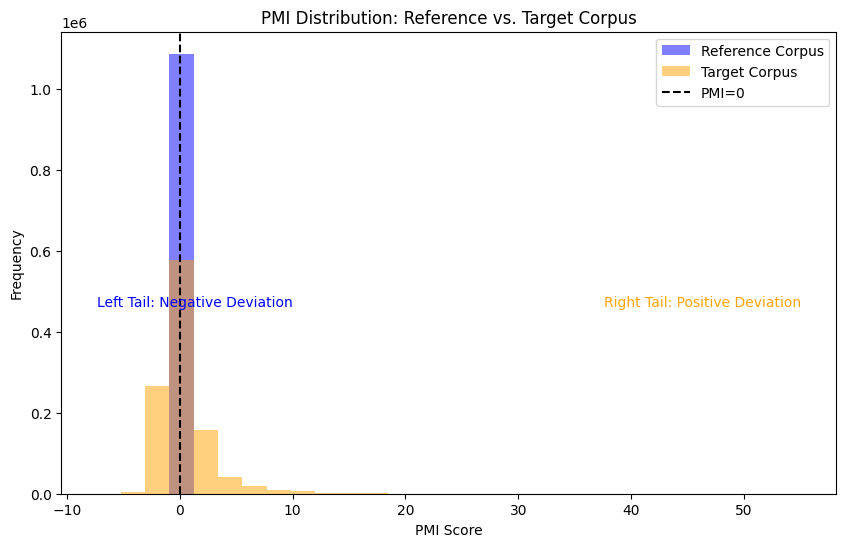

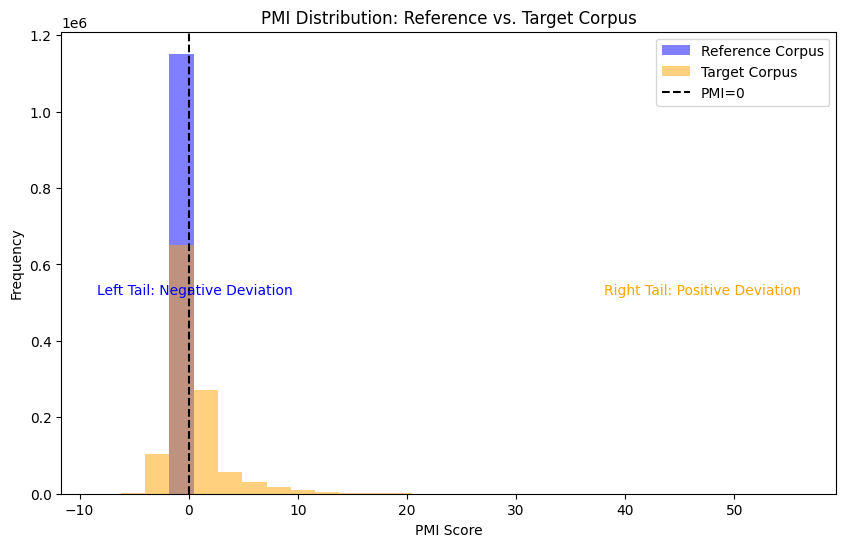

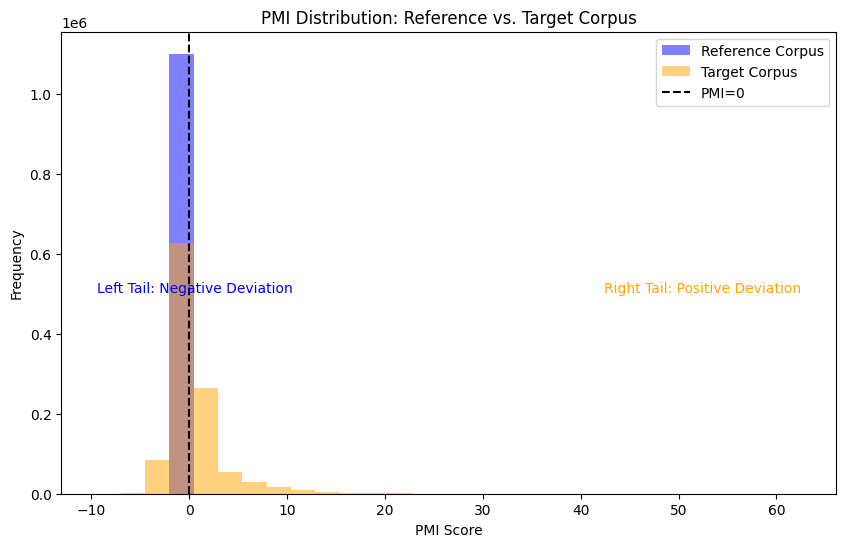

In [8]:
# plot histograms of PMI differences for each n-gram size
for n, ngram_info in pmi_differences.items():
    target_pmis = {ngram: info['delta_pmi'] for ngram, info in ngram_info.items()}
    ref_pmis = {ngram: 0 for ngram in target_pmis}
    plot_pmi_histograms({}, target_pmis, ref_pmis)